# まとめノート

今までの話をまとめる

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
% matplotlib inline
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from numpy.linalg import inv
from numpy.random import *
import numdifftools as nd
from sklearn import linear_model

## サンプルデータ

In [2]:
a = st.uniform()
s = st.norm()
e = st.norm()
M = 10000
T = 3000
random = 101
beta1 = 0.8
beta2 = -0.5
beta3 = -0.5
delta = -0.25

In [3]:
def mne(x, mu,delta,random, a):
    prob_x = 1 + (mu + x[1])/delta
    prob_y = 1 + (mu+x[0])/delta
    probs = np.cumsum([prob_x*prob_y, (1-prob_x)*prob_y, prob_x*(1-prob_y), (1-prob_x)*(1-prob_y)])
    prob = a.rvs(1, random_state = random)
    ind = np.searchsorted(probs, prob)
    if ind == 0:
        return [0,0,0]
    elif ind == 1:
        return [1,0,2]
    elif ind == 2:
        return [0,1,1]
    else:
        return [1,1,3]

def nash(x, true_mu, true_delta, random, a):
    if x[0] < -true_mu:
        if x[1] < -true_mu:
            return [0,0,0]
        else :
            return [0,1,1]
    elif -true_mu < x[0] < -true_mu -true_delta:
        if x[1] < -true_mu:
            return [1,0,2]
        elif -true_mu < x[1] < -true_mu -true_delta:
            return mne(x, true_mu,true_delta, random, a)
        else:
            return [0,1,1]
    else:
        if x[1] < -true_mu -true_delta:
            return [1,0,2]
        else:
            return [1,1,3]
        
def diff(p):
    p_0 = sum([True for i in data2[p, :, 2] if i == 0.0])/T
    p_2 = sum([True for i in data2[p, :, 2] if i == 3.0])/T
    return p_0 - p_2

def num(p):
    num0 = sum([True for i in data2[p, :, 2] if i == 0.0])
    num2 = sum([True for i in data2[p, :, 2] if i == 3.0])
    num1 = T - num0 - num2
    return num0, num1, num2

In [4]:
# M市場分のデータを作る。
data = e.rvs(size = (M,3), random_state = 101)
eps = s.rvs(size = (M,T,2), random_state = 18)
data2 = np.ones((M,T,3))
for m in range(M):
    for t in range(T):
        data2[m, t, :] = nash(eps[m, t, :], data[m, 0]*beta1 + data[m, 1]*beta2, delta, random, a)

d = np.array([diff(p) for p in range(M)])
d2 = np.reshape(np.array([num(p) for p in range(M)]), (M, 3))
df = pd.DataFrame({"Pop" : data[:,0], "Dist1" : data[:, 1], "Dist2" : data[:, 2], "diff" : d, "num0":d2[:, 0], "num1":d2[:, 1], "num2":d2[:, 2]})
df2 = df[(beta1 * df.Pop + beta2 * df.Dist1 + delta > 0) & (beta1 * df.Pop + beta2 * df.Dist2 + delta > 0)]
df2.to_csv("robust_norm.csv")

## 推定

In [5]:
df = pd.read_csv("robust_norm.csv")
pop = df[["Pop"]].values[:, 0]
dist1 = df[["Dist1"]].values[:, 0]
dist2 = df[["Dist2"]].values[:, 0]
num0 = df[["num0"]].values[:, 0]
num2 = df[["num2"]].values[:, 0]
diff = df[["diff"]].values[:, 0]

In [6]:
def br(x):
    xb1 = x[0] * pop + x[1] * dist1
    xb2 = x[0] * pop + x[1] * dist2
    logl = num0*(np.log(s.cdf(-xb1)*s.cdf(-xb2)) -np.log(1-s.cdf(-xb1)*s.cdf(-xb2)-s.cdf(xb1+x[2])*s.cdf(xb2+x[2]))) \
    + num2*(np.log(s.cdf(xb1+x[2])*s.cdf(xb2+x[2])) - np.log(1-s.cdf(-xb1)*s.cdf(-xb2)-s.cdf(xb1+x[2])*s.cdf(xb2+x[2])))\
    + T*np.log(1-s.cdf(-xb1)*s.cdf(-xb2)-s.cdf(xb1+x[2])*s.cdf(xb2+x[2]))
    return sum(logl)

def br1(x):
    xb1 = x[0] * pop + x[1] * dist1
    xb2 = x[0] * pop + x[1] * dist2
    logl = num0*(np.log(s.cdf(-xb1)*s.cdf(-xb2)) -np.log(1-s.cdf(-xb1)*s.cdf(-xb2)-s.cdf(xb1+x[2])*s.cdf(xb2+x[2]))) \
    + num2*(np.log(s.cdf(xb1+x[2])*s.cdf(xb2+x[2])) - np.log(1-s.cdf(-xb1)*s.cdf(-xb2)-s.cdf(xb1+x[2])*s.cdf(xb2+x[2])))\
    + T*np.log(1-s.cdf(-xb1)*s.cdf(-xb2)-s.cdf(xb1+x[2])*s.cdf(xb2+x[2]))
    return logl

def robust(x):
    xb1 = x[0] * pop + x[1] * dist1
    xb2 = x[0] * pop + x[1] * dist2
    r = (diff + s.cdf(xb1 + x[2])*s.cdf(xb2 + x[2]) - s.cdf(-xb1)*s.cdf(-xb2))**2
    return -sum(r)

def robust1(x):
    xb1 = x[0] * pop + x[1] * dist1
    xb2 = x[0] * pop + x[1] * dist2
    r = diff + s.cdf(xb1 + x[2])*s.cdf(xb2 + x[2]) - s.cdf(-xb1)*s.cdf(-xb2)
    return r

def NR(initial, fun, tol, maxit):
    theta = initial
    for i in range(0,maxit):
        G = nd.Gradient(fun)(theta)
        H = nd.Hessian(fun)(theta)
        del_theta = inv(H).dot(G)
        theta = theta - del_theta
        if np.linalg.norm(del_theta) < tol:
            print("NR終わり")
            break
    return theta

In [7]:
# 推定
tole = 0.000005
maxx = 100000
initial = [0.8,-0.5,-0.25]
result_br = NR(initial, br, tole, maxx)
result_rob = NR(initial, robust, tole, maxx)

/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWarni

NR終わり
NR終わり


In [8]:
result_br

array([ 0.73263699, -0.42756166, -0.14524672])

In [9]:
result_rob

array([ 0.7938106 , -0.48693054, -0.23378507])

## ハウスマン検定

In [10]:
def hausman(result1, result2):
    H_br = nd.Hessian(br)(result1)
    inv_H_br = inv(H_br)
    tri_1 = -inv_H_br

    J_br = nd.Jacobian(br1)(result1)
    circle_1 = np.dot(J_br.T, J_br)

    G_rob = nd.Gradient(robust)(result2)
    a = np.matrix(G_rob)
    tri_3 = -np.dot(inv(np.dot(a.T, a)), a.T)

    b = np.matrix(robust1(result2)).T
    circle_3 = np.dot(J_br.T, b)

    circle_6 = robust(result2)

    A_11 = np.dot(np.dot(tri_1, circle_1), tri_1.T)/M
    A_33 = np.dot(np.dot(tri_3, circle_6), tri_3.T)/M
    A_13 = np.dot(np.dot(tri_1, circle_3), tri_3.T)/M
    A_31 = np.dot(np.dot(tri_3, circle_3.T), tri_1.T)/M
    
    avar = A_11 - A_13 -A_31 + A_33
    gap = np.matrix(result1 - result2)
    h = M * np.dot(np.dot(gap, inv(avar)), gap.T)
    
    return h, np.rank(avar)

In [11]:
h, rank = hausman(result_br, result_rob)

/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in add
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * t

In [12]:
print(h)
print(rank)

[[  8.93550846e+09]]
2


## M市場ケース

多分ロジットの予測を使うのは理論的に正しくない。

ちゃんと定式化しよう。

In [25]:
# 実現した参入企業数を出す
df = pd.read_csv("robust_norm.csv")
seed(1234)
m = df.shape[0]
draw = randint(1,T+1,m) 
df["draw"] = draw
df["realized_entry"] = df.apply(lambda x: 0 if(x["draw"] <= x["num0"]) else 1 if(x["draw"] <= x["num1"]) else 2, axis = 1)

df["popdist1"] = df["Pop"] * df["Dist1"]
df["popdist2"]= df["Pop"] * df["Dist2"]
df["dist1dist2"]= df["Dist2"] * df["Dist1"]
df["pop_sq"] = df["Pop"]**2
df["dist1_sq"] = df["Dist1"]**2
df["dist2_sq"] = df["Dist2"]**2

df["pop_tr"] = df["Pop"]**3
df["dist1_tr"] = df["Dist1"]**3
df["dist2_tr"] = df["Dist2"]**3
df["pop_sqdist1"] = df["Pop"]**2 * df["Dist1"]
df["pop_sqdist2"] = df["Pop"]**2 * df["Dist2"]
df["dist1_sqpop"] = df["Pop"] * df["Dist1"]**2
df["dist1_sqdist2"] = df["Dist2"] * df["Dist1"]**2
df["dist2_sqpop"] = df["Pop"] * df["Dist2"]**2
df["dist2_sqdist1"] = df["Dist1"] * df["Dist2"]**2

In [26]:
# logit
logreg = linear_model.LogisticRegression(C=1e5, penalty='l1')
Y = df.realized_entry
X = df.drop(["Unnamed: 0", "diff", "num0", "num1", "num2", "draw", "realized_entry"],axis = 1)
logreg.fit(X, Y)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

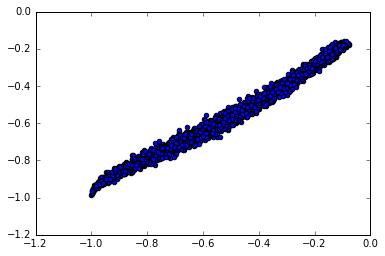

In [27]:
# diff estimation
df["diff_est"] = logreg.predict_proba(X)[:, 0] - logreg.predict_proba(X)[:, 2]
d = df["diff"].values
d_est = df["diff_est"].values
plt.scatter(d, d_est)

In [28]:
# 推定値を用いてRobust推定
diff = df[["diff_est"]].values[:, 0]
result_rob2 = NR(initial, robust, tole, maxx)

NR終わり


In [29]:
# サンプル数多くしてもバイアスは消えないな
# 一致性がないならhausmanやっても仕方ない
result_rob2

array([ 0.6218881 , -0.34439028,  0.11658492])